# DAM group project: SecuRun

## 1. Import Libraries

In [1]:
# General packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from itertools import combinations

# Geodata packages
import folium
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from cartopy.io.img_tiles import OSM
import cartopy.crs as ccrs
from pyproj import Proj, transform
from skimage.measure import block_reduce

# Linear programming packages
import gurobipy as gp
from gurobipy import GRB,quicksum

## 2. Loading and transforming data
Below, the resolution and map extent is set, which will eventually be used to structure the raw data

In [2]:
# We will structure the data in a long/lat grid system at 4 decimals' precision
decimals = 4
steps = 10**-decimals

# We will focus on central london
min_long = -0.200
max_long = 0.000
min_lat = 51.450
max_lat = 51.550

# Creating the columns & rows indexes of the grid system, i.e. the longs & lats
cols = sorted(np.round(np.arange(min_long, max_long, steps), decimals))
rows = sorted(np.round(np.arange(min_lat, max_lat, steps), decimals),
              reverse= True)

### 2.1 Crime data
Below we load and transform london crime data. The dataset covers crimes investigated by the City of London Police and Metropolitan Police Service between January 2023 and December 2023. The dataset can be accessed at https://data.police.uk/data/

In [3]:
### Loading all raw crime data files ###

# Get current working directory
curr_dir = os.getcwd()

# Create a dataframe that will store the crime data
crime_data = pd.DataFrame()

# Find all files in directory and subdirectories
for subdir, dirs, files in os.walk(curr_dir):
    for file in files:
        # Check if the file ends with 'metropolitan-street.csv', i.e. is a Metropolitan Police dataset
        if file.endswith('metropolitan-street.csv'):
            file_path = os.path.join(subdir, file)
            temp_df = pd.read_csv(file_path)
            # Add all metropolitan police data sets to crime_data
            crime_data = pd.concat([crime_data, temp_df], ignore_index=True)

        # Check if the file ends with 'city-of-london-street.csv', i.e. is a City of London Police dataset
        elif file.endswith('city-of-london-street.csv'):
            file_path = os.path.join(subdir, file)
            temp_df = pd.read_csv(file_path)
            # Add all City of London Police data to crime_data
            crime_data = pd.concat([crime_data, temp_df], ignore_index=True)

In [4]:
### Transforming raw crime data files ###

# Change precision of raw data
crime_data["Longitude"] = crime_data["Longitude"].apply(lambda x: round(x, decimals))
crime_data["Latitude"] = crime_data["Latitude"].apply(lambda x: round(x, decimals))

# Change extent of raw data
crime_data = crime_data[(min_lat < crime_data.Latitude) & (crime_data.Latitude < max_lat) &\
                      (min_long < crime_data.Longitude) & (crime_data.Longitude < max_long)]

In [5]:
### Populating grid system with crime data ###

# Creating grid system to be populated
grid = np.zeros((len(rows), len(cols)))

crime_df = pd.DataFrame(grid,
                        columns = cols,
                        index = rows)

# Updating grid system with number of crimes in each grid cell
for index, row in crime_data[["Longitude", "Latitude"]].dropna().iterrows():
    long = float(row['Longitude'])
    lat = float(row['Latitude'])
    crime_df.loc[lat, long] += 1
    
# Scaling grid system from number of crimes to proporation of crime
crime_df = crime_df / crime_df.sum().sum()

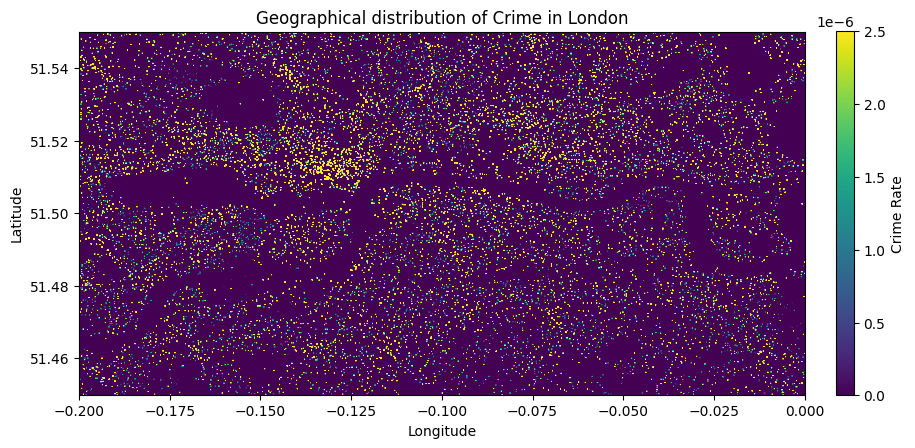

In [6]:
# Visualization of the geographical distribution of crime in London
fig, ax = plt.subplots(figsize=(10, 6))

img = plt.imshow(crime_df,
                 extent=[min_long, max_long, min_lat, max_lat],
                 vmax=0.0000025)

plt.title('Geographical distribution of Crime in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(img, label='Crime Rate', fraction=0.0235, pad=0.04)  

plt.show()

### 2.2 Green data
Below we load and transform london vegetation data, such as parks, trees etc. The dataset includes high resolution data obtained through aerial imagery in 2019. The dataset is provided by the Greater London Authority and can be accessed through the London Datastore by following this link: https://data.london.gov.uk/dataset/green-and-blue-cover

The data used comes from the "blueandgreen_ndvi0.05.zip" file

In [7]:
# The geodata is split into numbered files depending on area, below are the files of central london 
# See the report "how-green-is-london-report-and-methodology-2019.pdf",
# at https://data.london.gov.uk/dataset/green-and-blue-cover) for more information

green_data_tiles = [261, 262, 263, 264, 265, 266,
                    284, 285, 286, 287, 288, 289,
                    307, 308, 309, 310, 311, 312,
                    330, 331, 332, 333, 334, 335,
                    353, 354, 355, 356, 357, 358,
                    376, 377, 378, 379, 380, 381,
                    399, 400, 401, 402, 403, 404,
                    422, 423, 424, 425, 426, 427]

In [8]:
### Load green data files of interest ###

# Creating grid system to be populated
green_data = pd.DataFrame()

# Load the 0.05 NVDI green data files of central london
for tile in green_data_tiles:
    temp_file = gpd.read_file(curr_dir+f'/green_data/ndvi_landcover_merge_{tile}.shp')
    green_data = pd.concat([green_data, temp_file], ignore_index=True)


In [9]:
### Transforming raw green data files ###

# Focusing on green areas (not blue, i.e. water)
green_data = green_data[green_data.cover_type == "green"]

# Removing overview geometries (one included for each tile-file)
green_data = green_data[green_data.tile_num != 0]

# Reprojection to geographic coordinates "WGS84", i.e. longs and lats
green_data = green_data.to_crs(epsg=4326)

In [10]:
### Populating grid system with green data ###

# Changing extent of data
transform_new = from_bounds(min_long, 
                            min_lat, 
                            max_long, 
                            max_lat, 
                            len(cols), 
                            len(rows))

# Rasterize using the new extent and transform
grid_new = rasterize(
    shapes=((geometry, 1) for geometry in green_data.geometry),
    out_shape=(len(rows), len(cols)),
    transform=transform_new,
    fill=0,
    merge_alg=rasterio.enums.MergeAlg.replace
)

# Making the green_data into a dataframe
green_df = pd.DataFrame(grid_new,
                        columns = cols,
                        index = rows)

# Scaling grid system to proporation of vegetation
green_df = green_df / green_df.sum().sum()

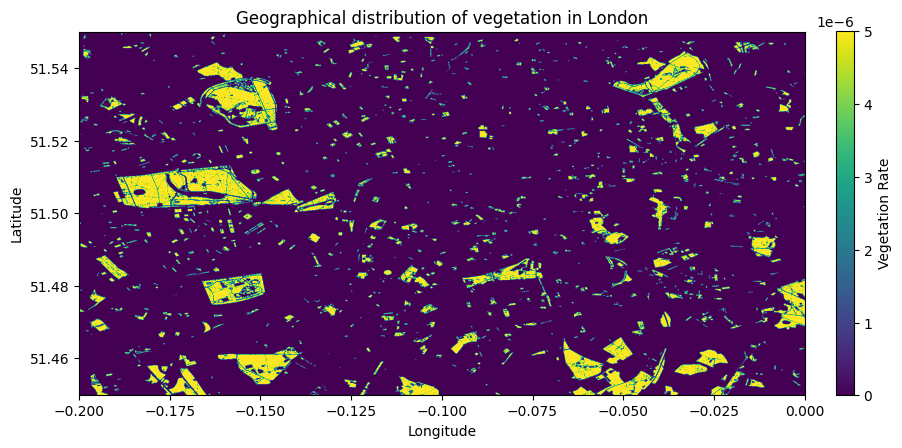

In [11]:
# Visualization of the geographical distribution of vegetation in London
fig, ax = plt.subplots(figsize=(10, 6))

img = plt.imshow(green_df,
                 extent=[min_long, max_long, min_lat, max_lat],
                 vmax=0.000005)

plt.title('Geographical distribution of vegetation in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(img, label='Vegetation Rate', fraction=0.0235, pad=0.04)  

plt.show()

### 2.3 Traffic accident data
Below we load and transform london traffic accident data. The data set includes geodata of traffic collisions in london from 1979 to 2022, of which we will use data from 2010 and forward to best reflect the current traffic accident risk in london. The data is provided by the Department of Transport and can be accessed at: https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

The data used comes from the dataset "Road Safety Data - Collisions 1979 - Latest Published Year"

In [12]:
### Load accident data ###
acc_data = pd.read_csv(curr_dir+"/traffic_acc_data/dft-road-casualty-statistics-collision-1979-latest-published-year.csv")

/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_25928/2966039337.py:2: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_data = pd.read_csv(curr_dir+"/traffic_acc_data/dft-road-casualty-statistics-collision-1979-latest-published-year.csv")


In [13]:
### Transforming raw accident data files ###

# Focusing on recent accidents
acc_data = acc_data[acc_data.accident_year > 2010]

# Change precision of raw data
acc_data["longitude"] = acc_data["longitude"].apply(lambda x: round(x, decimals))
acc_data["latitude"] = acc_data["latitude"].apply(lambda x: round(x, decimals))

# Change extent of raw data
acc_data = acc_data[(min_lat < acc_data.latitude) & (acc_data.latitude < max_lat) &\
                (min_long < acc_data.longitude) & (acc_data.longitude < max_long)]

In [14]:
### Populating grid system with accident data ###

# Creating grid system to be populated
grid = np.zeros((len(rows), len(cols)))

acc_df = pd.DataFrame(grid,
                      columns = cols,
                      index = rows)

# Populating grid with accident data
for index, row in acc_data[["longitude", "latitude"]].dropna().iterrows():
    long = float(row['longitude'])
    lat = float(row['latitude'])
    acc_df.loc[lat, long] += 1
    
# Scaling grid system to proporation of vegetation
acc_df = acc_df / acc_df.sum().sum()

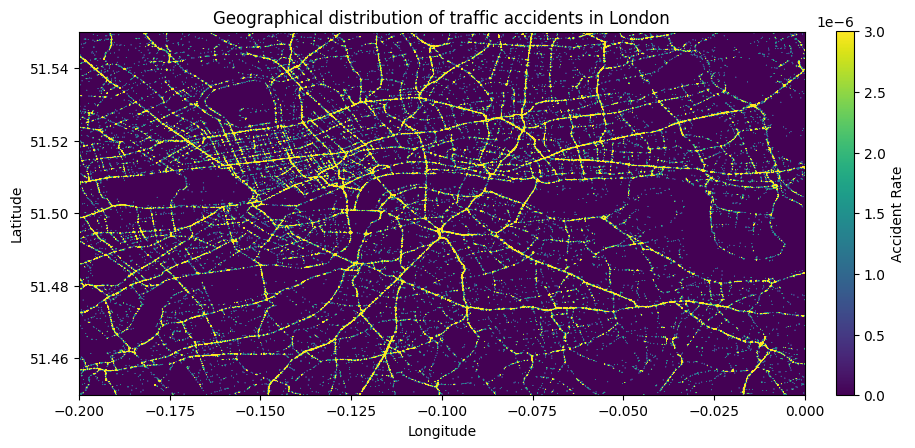

In [15]:
# Visualization of the geographical distribution of vegetation in London
fig, ax = plt.subplots(figsize=(10, 6))

img = plt.imshow(acc_df,
                 extent=[min_long, max_long, min_lat, max_lat],
                 vmax=0.000003)

plt.title('Geographical distribution of traffic accidents in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(img, label='Accident Rate', fraction=0.0235, pad=0.04)  

plt.show()

### 2.4 Resampling maps to lower resolution
Downsampling data to enable optimization

In [16]:
### Downsampling data ###

# Number of cells of old resolution to represent one cell in the new grid (along 1 dimension)
cells_per_cell = 50

# Creating block based on new resolution
block_size = (cells_per_cell, cells_per_cell)

# Downsampling crime data
downsampled_crime = block_reduce(np.array(crime_df).astype(float), block_size, func=np.sum)

# Downsampling green data
downsampled_green = block_reduce(np.array(green_df).astype(float), block_size, func=np.sum)

# Downsampling traffic accident data
downsampled_acc = block_reduce(np.array(acc_df).astype(float), block_size, func=np.sum)


In [17]:
### Creating downsampled dataframes ###

# Creating columns & rows indexes for the downsampled the grid system, i.e. the longs & lats
ds_cols = sorted(np.round(np.arange(min_long, max_long, steps*cells_per_cell), decimals))
ds_rows = sorted(np.round(np.arange(min_lat, max_lat, steps*cells_per_cell), decimals),
                 reverse= True)

# Creating downsampled dataframes
downsampled_crime_df = pd.DataFrame(downsampled_crime,
                                   columns = ds_cols,
                                   index = ds_rows)

downsampled_green_df = pd.DataFrame(downsampled_green,
                                   columns = ds_cols,
                                   index = ds_rows)

downsampled_acc_df = pd.DataFrame(downsampled_acc,
                                   columns = ds_cols,
                                   index = ds_rows)

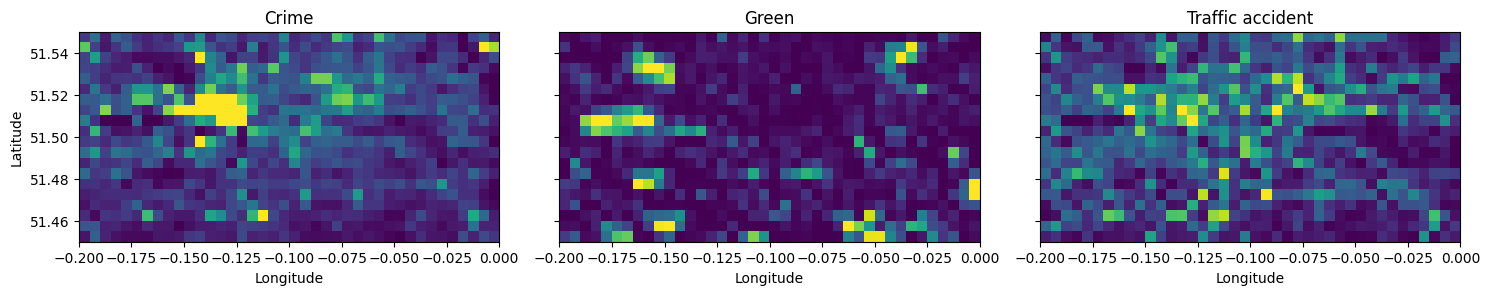

In [18]:
### Plotting downsampled data ###
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plotting crime data
ax1.imshow(downsampled_crime_df,
           extent=[min_long, max_long, min_lat, max_lat],
           vmax=0.005)
ax1.set_title('Crime')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Plotting green data
ax2.imshow(downsampled_green_df,
           extent=[min_long, max_long, min_lat, max_lat],
           vmax=0.01)
ax2.set_title('Green')
ax2.set_xlabel('Longitude')

# Plotting traffic accident data
ax3.imshow(downsampled_acc_df,
           extent=[min_long, max_long, min_lat, max_lat],
           vmax=0.005)
ax3.set_title('Traffic accident')
ax3.set_xlabel('Longitude')

# Plotting
plt.tight_layout()
plt.show()


In [19]:
# New shape of data
if downsampled_acc_df.shape == downsampled_crime_df.shape == downsampled_green_df.shape:
    print("New shape:", downsampled_acc_df.shape)

New shape: (20, 40)


In [20]:
# Confirming that scaling is maintained
if downsampled_acc_df.sum().sum() == downsampled_crime_df.sum().sum() == downsampled_green_df.sum().sum():
    print("Cells of each respective map sums to:", downsampled_acc_df.sum().sum())

Cells of each respective map sums to: 1.0


## 3 Route optimization
This section takes the optimisation step by step with code comments - a more compact version (for demo purposes) is included in section 4

### 3.1 Defining functions

In [21]:
# Takes long/lat of two points and returns distance in km
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees).
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

# Takes multiple point-to-point paths and returns the points visited as one sequence
def get_optimal_sequence(routes, home_coo):
    opt_sequence = []
    opt_sequence.append(home_coo)
    
    routes = dict(routes)
    current_key = home_coo
    
    for key in range(len(routes.keys())):
        opt_sequence.append(routes[current_key])
        current_key = routes[current_key]
        
    return opt_sequence

# Takes number and returns rounded number on a specified base
def custom_round(x, base):
    return( base * round(x/base))

# Takes a route and returns crime, green and accident scores compared to area average
def get_route_stats(point_seq):
    crime_score = 0
    green_score = 0
    acc_score = 0
    
    for point in point_seq[1:]:
        crime_score += downsampled_crime_df.loc[point[0], point[1]]
        green_score += downsampled_green_df.loc[point[0], point[1]]
        acc_score += downsampled_acc_df.loc[point[0], point[1]]
        
    crime_score = (crime_score/len(point_seq[1:])) / downsampled_crime_df.mean().mean()
    green_score = (green_score/len(point_seq[1:])) / downsampled_green_df.mean().mean()
    acc_score = (acc_score/len(point_seq[1:])) / downsampled_acc_df.mean().mean()
    
    labels = ['Crime Score', 'Green Score', 'Accident Score']
    scores = [crime_score, green_score, acc_score]
    
    fig, ax = plt.subplots(figsize=(5,2))
    ax.bar(labels, scores, color=['red', 'green', 'blue'])
    ax.set_title('Route Statistics - Normalized Scores')
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
    ax.annotate('Area Average', xy=(1, 1), xytext=(2.9, 1.05),
                fontsize=9, ha='center')
    
    plt.show()

### 3.2 Input for route optimisation problem

In [22]:
### Input for the optimisation problem ###

# Home coordinates (lat, long)
home = (51.52, -0.13)

# Min and max distance of route
min_distance = 5
max_distance = 6

# Factor weight (higher more important)
crime_weight = 3
green_weight = 1
acc_weight = 2



# Rounds coordinates to the resolution of the data
final_base = abs(round(downsampled_acc_df.columns[0] - downsampled_acc_df.columns[1], decimals))

home = (custom_round(home[0], base=final_base), 
        custom_round(home[1], base=final_base))

### 3.3 Optimisation model

In [23]:
### Limiting optimisation problem based on home location ###

# Filtering out coordinates within max_distance/2 from home - since other coordinates will not be relevant
active_coordinates = [(lat, lon) for lat in downsampled_crime_df.index for lon in downsampled_crime_df.columns 
                      if (haversine(home[1], home[0], lon, lat) <= max_distance/2)]

# Creating a dictionary of point-to-point distances between active coordinates
p_to_p_distances = {((from_long, from_lat, to_long, to_lat)): haversine(from_lat, from_long, to_lat, to_long)\
                    for from_long, from_lat in active_coordinates for to_long, to_lat in active_coordinates}


In [24]:
m = gp.Model("running")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-13


**Variables**

In [25]:
# Variable: variable for each point-to-point path (1=used, 0=not used)
routes = m.addVars(active_coordinates,active_coordinates, vtype=GRB.BINARY)

**Constraints**

In [26]:
# Constraint: we can only arrive at most once to each point
arrive_once_con = m.addConstrs(quicksum(routes[l1+l2] for l1 in active_coordinates) <= 1 for l2 in active_coordinates)

# Constraint: we can only depart at most once from each point
leave_once_con = m.addConstrs(quicksum(routes[l1+l2] for l2 in active_coordinates) <= 1 for l1 in active_coordinates)

# Constraint: we can not arrive and depart to the same point
must_move_con = m.addConstrs(routes[l1+l1] <= 0 for l1 in active_coordinates)
    
# Constraint: we must leave from home once
leave_home_con = m.addConstr(quicksum(routes[home+l] for l in active_coordinates) == 1)

# Constraint: we must arrive to home once
arrive_home_con = m.addConstr(quicksum(routes[l+home] for l in active_coordinates) == 1)
    
# Constraint: set max number of route points to 5, to limit complexity
route_points_con = m.addConstr(quicksum(routes[l1+l2] for l1 in active_coordinates for l2 in active_coordinates) == 5)

# Constraint: route length must be longer than min distance
min_dist_con = m.addConstr(quicksum(routes[l1+l2] * p_to_p_distances[l1+l2]\
                                for l1 in active_coordinates for l2 in active_coordinates) >= min_distance)

# Constraint: route length must be shorter than max distance
max_dist_con = m.addConstr(quicksum(routes[l1+l2] * p_to_p_distances[l1+l2]\
                                for l1 in active_coordinates for l2 in active_coordinates) <= max_distance)

# Constraint: distance between points must be larger than min distance / 5 to ensure that points are spread out
min_path_con = m.addConstrs(routes[l1+l2]*min_distance/5 <= p_to_p_distances[l1+l2] for l1 in active_coordinates for l2 in active_coordinates)


In [27]:
# Auxiliary variable: variable for visited points (1=visited, 0=not visited)
point_used = m.addVars(active_coordinates, vtype= GRB.BINARY)

# Constraint: We must leave and depart from each point visited, to create a circular route
leave_and_dep_con = m.addConstrs(quicksum(routes[l+point]+routes[point+l] for l in active_coordinates)\
                                 == 2*point_used[point] for point in active_coordinates)

# Constraint: breaking two point subtours (ex. A-B, B-A)
twop_subtour_con = m.addConstrs(routes[l1+l2]*routes[l2+l1] <= 0
                                for l1 in active_coordinates for l2 in active_coordinates)


**Objective function**

In [28]:
# Objective function: Minimise crime, maximise green & minimise traffic accident of route, based on weights
m.setObjective(quicksum((routes[l1+l2] * downsampled_crime_df.loc[l2[0], l2[1]])*crime_weight\
                        - (routes[l1+l2] * downsampled_green_df.loc[l2[0], l2[1]])*green_weight\
                        + (routes[l1+l2] * downsampled_acc_df.loc[l2[0], l2[1]])*acc_weight\
                        for l1 in active_coordinates for l2 in active_coordinates), GRB.MINIMIZE)

In [29]:
# Optimise 
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 23410 rows, 22952 columns and 182559 nonzeros
Model fingerprint: 0x17f4352b
Model has 22801 quadratic constraints
Variable types: 0 continuous, 22952 integer (22952 binary)
Coefficient statistics:
  Matrix range     [3e-01, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-04, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 22956 rows and 18014 columns
Presolve time: 0.08s
Presolved: 5242 rows, 7332 columns, 38679 nonzeros
Variable types: 0 continuous, 7332 integer (7332 binary)

Root relaxation: objective -2.506726e-02, 346 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

**Visualisation**

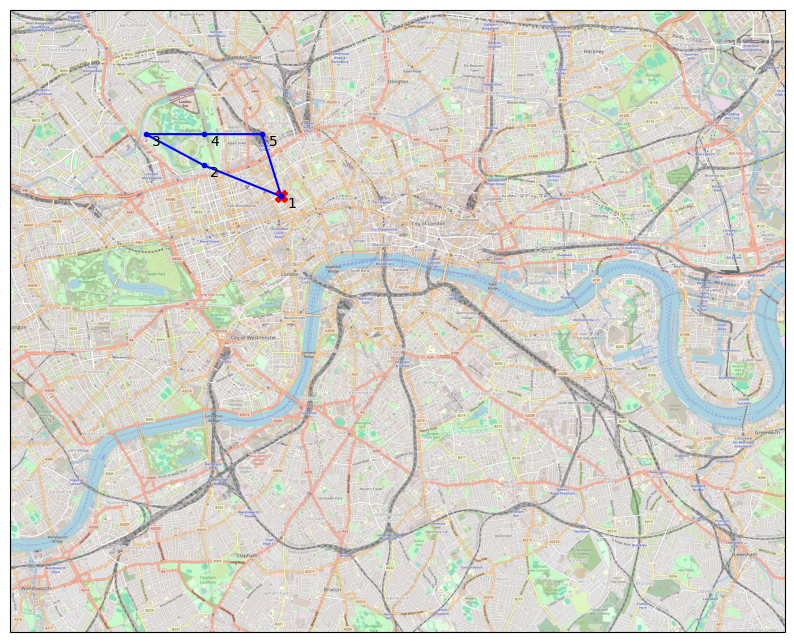

Total distance:  5.91 km


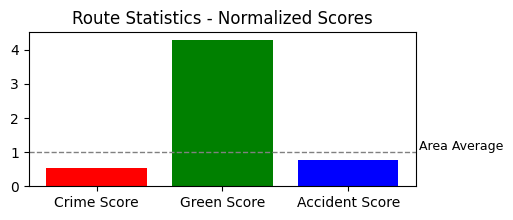

In [30]:
### Plotting optimisation ###

# Extracting paths taken
optimal_route = [[l1, l2] for l1 in active_coordinates for l2 in active_coordinates if routes[l1+l2].x > 0]

# Creating sequence of points visited
opt_seq = get_optimal_sequence(optimal_route, home)

plot_lats = [coord[0] for coord in opt_seq]
plot_long = [coord[1] for coord in opt_seq]

# Creating and shaping map
osm_background = OSM()
fig, ax = plt.subplots(figsize=(10, 10),subplot_kw={'projection': osm_background.crs})
ax.add_image(osm_background, 14)
ax.set_extent([min_long, max_long, min_lat, max_lat])

# Plot home point
ax.plot(home[1], home[0], marker='X', color='red', markersize=8, transform=ccrs.Geodetic())
# Plot path
ax.plot(plot_long, plot_lats, marker='o', color='blue', markersize=3, transform=ccrs.Geodetic())
# Plot point numbers
for i, (lat, long) in enumerate(opt_seq[:-1], start=1):
    ax.annotate(i, (long, lat), textcoords="offset points", xytext=(8,-8), ha='center', transform=ccrs.Geodetic())

plt.show()

# Printing route distance
distance = [routes[l1+l2].x * p_to_p_distances[l1+l2]\
            for l1 in active_coordinates for l2 in active_coordinates\
            if routes[l1+l2].x > 0]
print("Total distance: ", round(sum(distance),2), "km")

get_route_stats(opt_seq)

## 4. Prototype

### 4.1 Prototype function

In [31]:
# Compiling all model code into one function

def prototype(home, min_distance, max_distance, crime_weight, green_weight, acc_weight):

    
    final_base = abs(round(downsampled_acc_df.columns[0] - downsampled_acc_df.columns[1], decimals))
    home = (custom_round(home[0], base=final_base), 
            custom_round(home[1], base=final_base))

    active_coordinates = [(lat, lon) for lat in downsampled_crime_df.index for lon in downsampled_crime_df.columns 
                          if (haversine(home[1], home[0], lon, lat) <= max_distance/2)]
    p_to_p_distances = {((from_long, from_lat, to_long, to_lat)): haversine(from_lat, from_long, to_lat, to_long)\
                        for from_long, from_lat in active_coordinates for to_long, to_lat in active_coordinates}

    # Model
    m = gp.Model("running")
    routes = m.addVars(active_coordinates,active_coordinates, vtype=GRB.BINARY)

    arrive_once_con = m.addConstrs(quicksum(routes[l1+l2] for l1 in active_coordinates) <= 1 for l2 in active_coordinates)
    leave_once_con = m.addConstrs(quicksum(routes[l1+l2] for l2 in active_coordinates) <= 1 for l1 in active_coordinates)
    must_move_con = m.addConstrs(routes[l1+l1] <= 0 for l1 in active_coordinates)
    leave_home_con = m.addConstr(quicksum(routes[home+l] for l in active_coordinates) == 1)
    arrive_home_con = m.addConstr(quicksum(routes[l+home] for l in active_coordinates) == 1)
    route_points_con = m.addConstr(quicksum(routes[l1+l2] for l1 in active_coordinates for l2 in active_coordinates) == 5)
    min_dist_con = m.addConstr(quicksum(routes[l1+l2] * p_to_p_distances[l1+l2]\
                                    for l1 in active_coordinates for l2 in active_coordinates) >= min_distance)
    max_dist_con = m.addConstr(quicksum(routes[l1+l2] * p_to_p_distances[l1+l2]\
                                    for l1 in active_coordinates for l2 in active_coordinates) <= max_distance)
    min_path_con = m.addConstrs(routes[l1+l2]*min_distance/5 <= p_to_p_distances[l1+l2] for l1 in active_coordinates for l2 in active_coordinates)
    point_used = m.addVars(active_coordinates, vtype= GRB.BINARY)
    leave_and_dep_con = m.addConstrs(quicksum(routes[l+point]+routes[point+l] for l in active_coordinates)\
                                     == 2*point_used[point] for point in active_coordinates)
    twop_subtour_con = m.addConstrs(routes[l1+l2]*routes[l2+l1] <= 0
                                    for l1 in active_coordinates for l2 in active_coordinates)
    m.setObjective(quicksum((routes[l1+l2] * downsampled_crime_df.loc[l2[0], l2[1]])*crime_weight\
                            - (routes[l1+l2] * downsampled_green_df.loc[l2[0], l2[1]])*green_weight\
                            + (routes[l1+l2] * downsampled_acc_df.loc[l2[0], l2[1]])*acc_weight\
                            for l1 in active_coordinates for l2 in active_coordinates), GRB.MINIMIZE)
    m.Params.OutputFlag = 0
    m.optimize()


    # Plotting
    optimal_route = [[l1, l2] for l1 in active_coordinates for l2 in active_coordinates if routes[l1+l2].x > 0]
    opt_seq = get_optimal_sequence(optimal_route, home)

    plot_lats = [coord[0] for coord in opt_seq]
    plot_long = [coord[1] for coord in opt_seq]

    osm_background = OSM()
    fig, ax = plt.subplots(figsize=(10, 10),subplot_kw={'projection': osm_background.crs})
    ax.add_image(osm_background, 14)
    ax.set_extent([min_long, max_long, min_lat, max_lat])
    ax.plot(home[1], home[0], marker='X', color='red', markersize=8, transform=ccrs.Geodetic())
    ax.plot(plot_long, plot_lats, marker='o', color='blue', markersize=3, transform=ccrs.Geodetic())
    for i, (lat, long) in enumerate(opt_seq[:-1], start=1):
        ax.annotate(i, (long, lat), textcoords="offset points", xytext=(8,-8), ha='center', transform=ccrs.Geodetic())
    plt.show()

    distance = [routes[l1+l2].x * p_to_p_distances[l1+l2]\
                for l1 in active_coordinates for l2 in active_coordinates\
                if routes[l1+l2].x > 0]
    print("Total distance: ", round(sum(distance),2), "km")

    get_route_stats(opt_seq)

### 4.2 Prototype showcase
Below, different scenarios are tested

**Demo A**

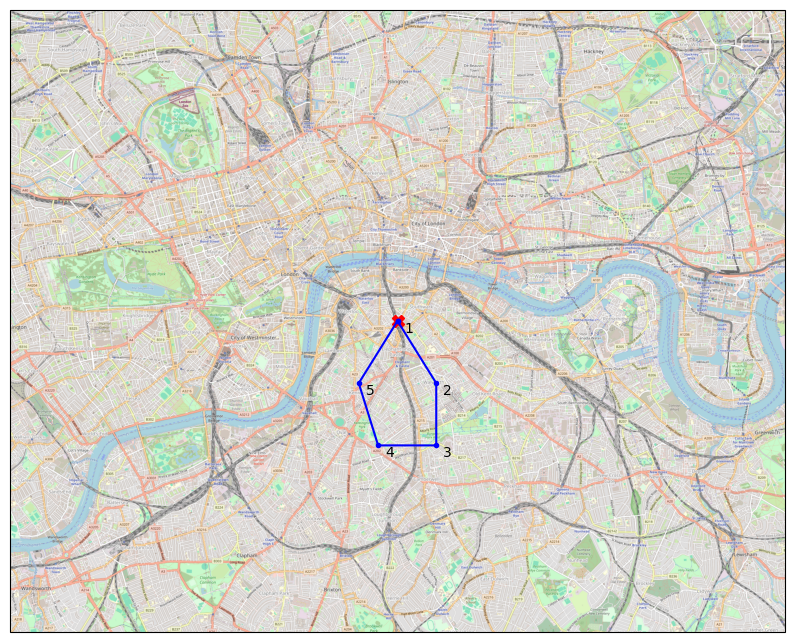

Total distance:  5.93 km


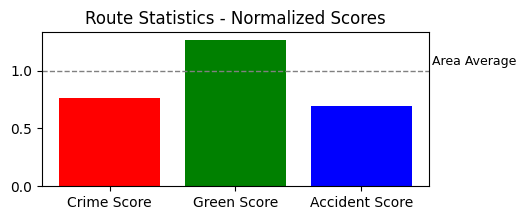

In [32]:
### USER INPUT ###
# Home coordinates (lat, long)
home = (51.50, -0.10)

# Min and max distance of route
min_distance = 5 
max_distance = 6

# Factor relative weight (higher more important, 0 deactivates factor)
crime_weight = 1
green_weight = 1
acc_weight = 5


### RUNNING MODEL ###
prototype(home, min_distance, max_distance, crime_weight, green_weight, acc_weight)

**Demo B**

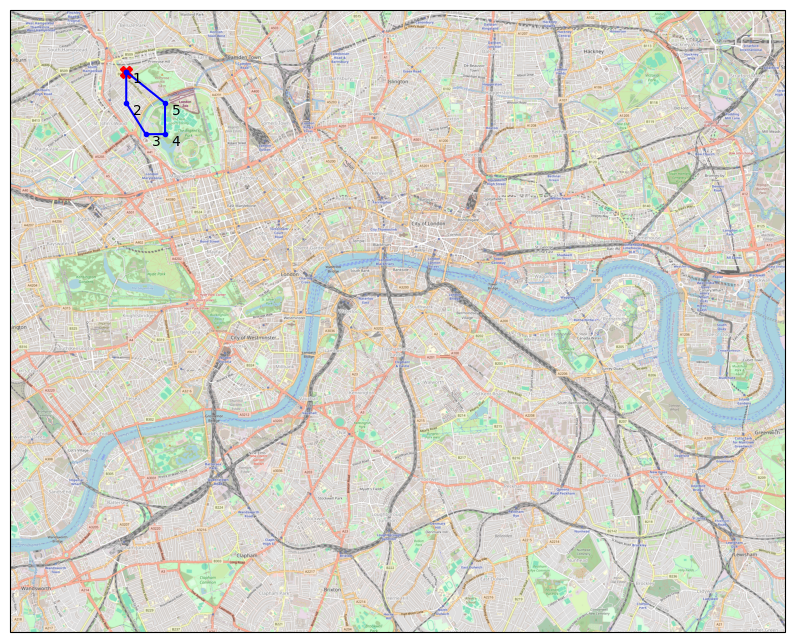

Total distance:  3.0 km


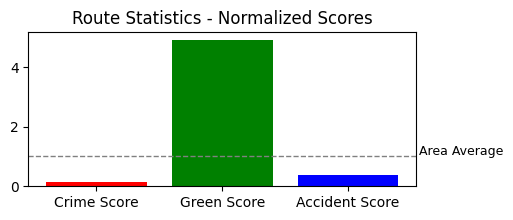

In [33]:
### USER INPUT ###
# Home coordinates (lat, long)
home = (51.54, -0.17)

# Min and max distance of route
min_distance = 1 
max_distance = 3

# Factor relative weight (higher more important, 0 deactivates factor)
crime_weight = 3
green_weight = 0
acc_weight = 1


### RUNNING MODEL ###
prototype(home, min_distance, max_distance, crime_weight, green_weight, acc_weight)

**Demo C**

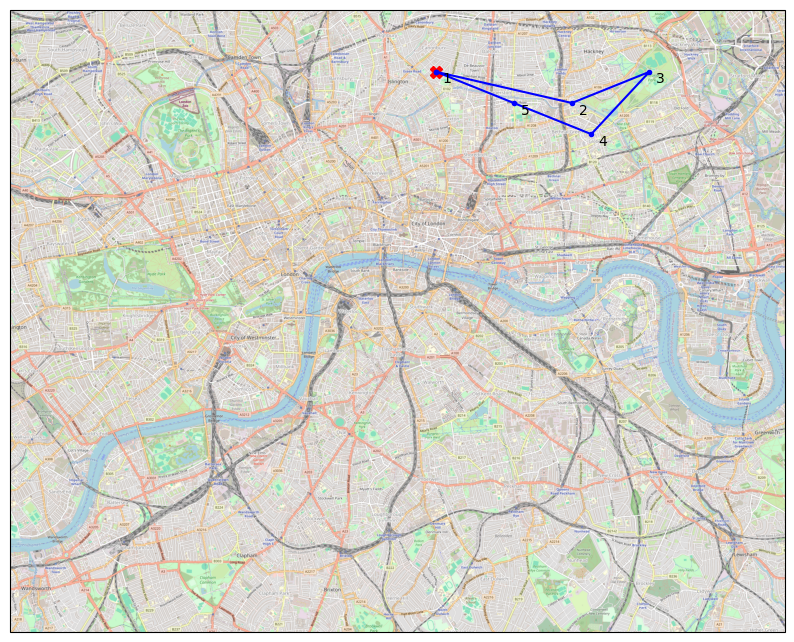

Total distance:  8.48 km


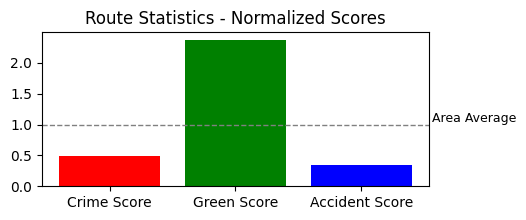

In [34]:
### USER INPUT ###
# Home coordinates (lat, long)
home = (51.54, -0.09)

# Min and max distance of route
min_distance = 7 
max_distance = 9

# Factor relative weight (higher more important, 0 deactivates factor)
crime_weight = 5
green_weight = 1
acc_weight = 10


### RUNNING MODEL ###
prototype(home, min_distance, max_distance, crime_weight, green_weight, acc_weight)